# EMICS 2021 Analysis (60 Hz)

This notebook and associated Python files contain data processing and analyses as reported in the final version of our workshop paper, including downsampling of data recorded from all three eye trackers to 60 Hz to match the lowest common denominator (EyeTribe). Statistical comparisons of model ROCs can be found in a separate (R-kernel) notebook. 

In [1]:
%matplotlib notebook

import json 

from figures import *
from analysis import *
from preprocessing import *

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

folder_data_in = 'data/raw'
folder_data = 'data/60Hz'
folder_out = 'results/60Hz'


In [2]:
# Preprocess raw data (uncomment to reproduce files)
#run_preprocessing(folder_data, folder_data_in, file_name='mentarith',
#                  target_framerate=60, pre_ms=0, post_ms=19999, base_samples=60)

In [3]:
# Load datasets
EL, ES, ET = load_data(folder_data, folder_data_in, file_name='mentarith')

* Data loaded.


## Average pupil response and Stoll (2013) slope-based classification

<IPython.core.display.Javascript object>


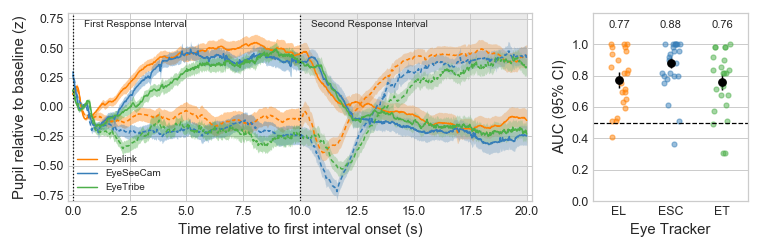

In [4]:
figure1(EL, ES, ET, Fs=60, auc_results=os.path.join(folder_out, 'stoll_auc.json'))
plt.savefig(os.path.join(folder_out, 'figure1.png'), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(folder_out, 'figure1.pdf'), bbox_inches='tight', dpi=300)

**Paper Fig. 1:** *Left*: Average pupil size change (z-scored; shading: $\pm$ 1 SEM) when participants performed mental arithmetic in the first (solid lines) and second (dashed lines) response interval. Dotted vertical lines indicate response period onsets. *Right*: Small circles: Individual Area under the ROC curve (AUC) when decoding responses using the slope method used in Stoll et al. (2013). Large circles and labels: AUC when decoding using all available responses for each device (using the method in Stoll et al. (2013); error bars: 95\% CI, dashed line: chance level).

Note that in the paper, we present only AUC results for brevity, but classification results using a simple accuracy measure (proportion of correct predictions) are qualitatively comparable (black markers: subject average and SEM): 

<IPython.core.display.Javascript object>


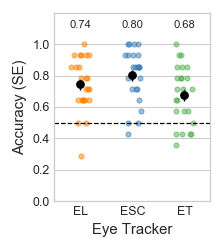

In [5]:
figure1B_accuracy(EL, ES, ET, Fs=60)

## Fit classification models

### Model selection using nested cross-validation

In [6]:
# Model fitting - nested cross-validation - trial traces
cv_trials = {'acc': {}, 'auc': {}, 'params': {}}
for tracker in [EL, ES, ET]:
    accsCV, aucsCV, paramsCV = train_nested_cv_classifiers(tracker.trials, tracker.trials_gt)
    cv_trials['acc'][tracker.name] = accsCV
    cv_trials['auc'][tracker.name] = aucsCV
    cv_trials['params'][tracker.name] = paramsCV
    print('* {:s} done.'.format(tracker.name))

* Eyelink done.
* EyeSeeCam done.
* EyeTribe done.


<IPython.core.display.Javascript object>


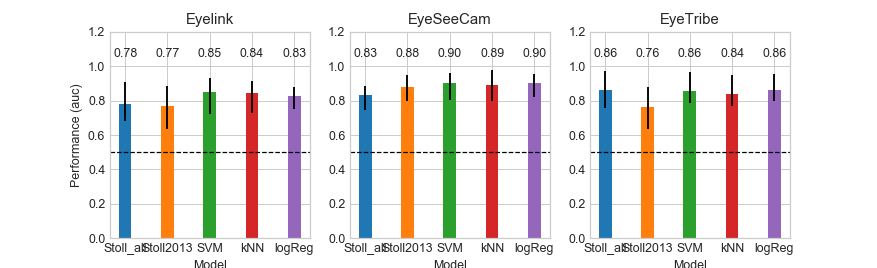

<IPython.core.display.Javascript object>


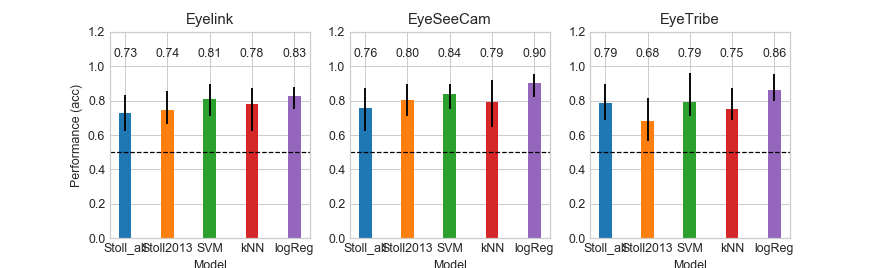

In [23]:
# Plot classifier results - trial traces
plot_classifier_dicts(cv_trials, measure='auc')
plot_classifier_dicts(cv_trials, measure='acc')

In [8]:
# Model fitting - nested cross-validation - interval traces
cv_intervals = {'acc': {}, 'auc': {}, 'params': {}}
for tracker in [EL, ES, ET]:
    accsCV, aucsCV, paramsCV = train_nested_cv_classifiers(tracker.periods, tracker.periods_gt)
    cv_intervals['acc'][tracker.name] = accsCV
    cv_intervals['auc'][tracker.name] = aucsCV
    cv_intervals['params'][tracker.name] = paramsCV
    print('* {:s} done.'.format(tracker.name))

* Eyelink done.
* EyeSeeCam done.
* EyeTribe done.


<IPython.core.display.Javascript object>


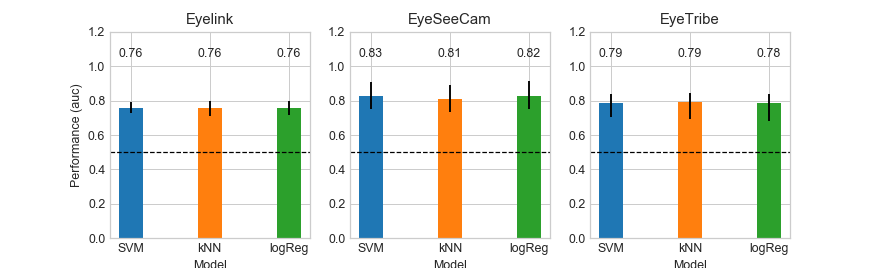

<IPython.core.display.Javascript object>


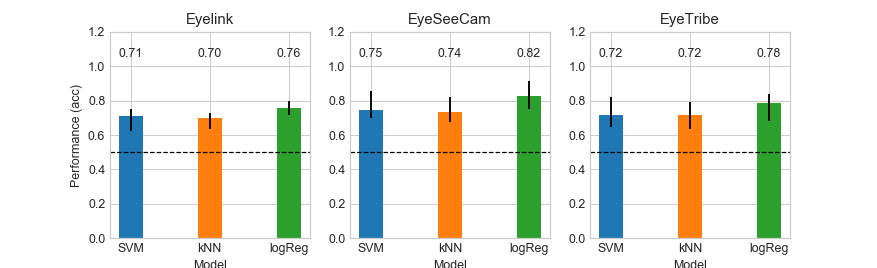

In [9]:
# Plot classifier results - interval traces
plot_classifier_dicts(cv_intervals, measure='auc')
plot_classifier_dicts(cv_intervals, measure='acc')

In [10]:
# Save all cross-validation results to JSON
cv_results = {'trials': cv_trials, 'intervals': cv_intervals}
with open(os.path.join(folder_out, 'crossval_results.json'), 'w') as pf:
    pf.write(json.dumps(cv_results))

### Re-fit best-performing model on the whole dataset

In [11]:
# Fit final models to all data using the parameters chosen in CV
models = {'LogR': LogisticRegression(C=0.0001, max_iter=10000),
          'kNN':  KNeighborsClassifier(n_neighbors=50),
          'SVM':  SVC(C=1, gamma=0.0001, probability=True)}
final_results = {'Eyelink': {}, 'EyeSeeCam': {}, 'EyeTribe': {}}

for tracker in [EL, ES, ET]:
    final_results[tracker.name] = fit_final_models(tracker, models)

trials/LogR, acc=0.798, auc=0.852
trials/kNN, acc=0.792, auc=0.867
trials/SVM, acc=0.795, auc=0.867
trials/Stoll2013, acc=0.744, auc=0.772
trials/Stoll_all, acc=0.729, auc=0.790
intervals/LogR, acc=0.698, auc=0.759
intervals/kNN, acc=0.704, auc=0.769
intervals/SVM, acc=0.717, auc=0.767
trials/LogR, acc=0.824, auc=0.903
trials/kNN, acc=0.812, auc=0.905
trials/SVM, acc=0.848, auc=0.918
trials/Stoll2013, acc=0.801, auc=0.883
trials/Stoll_all, acc=0.759, auc=0.833
intervals/LogR, acc=0.719, auc=0.805
intervals/kNN, acc=0.751, auc=0.826
intervals/SVM, acc=0.740, auc=0.825
trials/LogR, acc=0.798, auc=0.876
trials/kNN, acc=0.804, auc=0.878
trials/SVM, acc=0.815, auc=0.889
trials/Stoll2013, acc=0.679, auc=0.759
trials/Stoll_all, acc=0.786, auc=0.864
intervals/LogR, acc=0.714, auc=0.785
intervals/kNN, acc=0.746, auc=0.810
intervals/SVM, acc=0.723, auc=0.797


In [12]:
# Save model data
with open(os.path.join(folder_data, 'final_models.pkl'), 'wb') as pf:
    pickle.dump(final_results, pf)

# Export as DataFrame for R pROC analysis
results_df = results_to_df(final_results)
results_df.to_csv(os.path.join(folder_out, 'predictions.csv'), sep='\t', index=False)

## Classification of different pupil trace lengths

In [18]:
# Trace-length classification, full trials
svm_acc_trials, svm_auc_trials = fit_trial_trace_length_svm([EL, ES, ET], time_windows=80, 
                                                            outer_folds=7, C=1, gamma=0.0001)

Eyelink done.
EyeSeeCam done.
EyeTribe done.


In [19]:
# Trace-length classification, separate response intervals
svm_acc_intervals, svm_auc_intervals = fit_interval_trace_length_svm([EL, ES, ET], time_windows=40, 
                                                            outer_folds=7, C=1, gamma=0.0001)

Eyelink done.
EyeSeeCam done.
EyeTribe done.


In [20]:
# Save trace-length SVM results
svm_results = {'trials': {'acc': svm_acc_trials, 'auc': svm_auc_trials},
               'intervals': {'acc': svm_acc_intervals, 'auc': svm_auc_intervals}}

with open(os.path.join(folder_out, 'trace_results.json'), 'w') as pf:
    pf.write(json.dumps(svm_results))

## Classification results

In [21]:
# Load data from JSON (uncomment this to just reproduce the plot)
#with open(os.path.join(folder_out, 'crossval_results.json'), 'r') as pf:
#    cv_results = json.load(pf)
#with open(os.path.join(folder_out, 'trace_results.json'), 'r') as pf:
#    svm_results = json.load(pf)

<IPython.core.display.Javascript object>


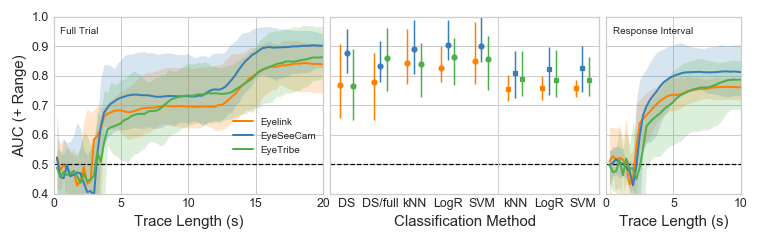

In [22]:
# Paper Figure 2
figure2(cv_results['trials']['auc'], svm_results['trials']['auc'], 
        cv_results['intervals']['auc'], svm_results['intervals']['auc'])
plt.savefig(os.path.join(folder_out, 'figure2.png'), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(folder_out, 'figure2.pdf'), bbox_inches='tight', dpi=300)

**Paper Fig. 2:** Decoding Analysis. *Left:* AUC of the best-performing SVM model when trained and tested on time windows in steps of 250 ms (7-fold CV). *Middle:* Average cross-validation performance (AUC) of different algorithms in trial decoding (left; circles) and response interval decoding (right; squares). DS: Difference slope method - timing as in [35]; DS/full: DS method applied to full trial duration. *Right:* Best model (SVM) AUC when trained and tested on separate response intervals, 250 ms intervals. Error bars / shading: AUC range in 7-fold CV. Black dashed line: chance level.